In [71]:
# adapted from Zijin Gu: https://github.com/zijin-gu/scfc-coupling
#     """This code takes as input each subject's covariance matrix saved to a .mat file as a variable 'C', and a list
#     of these matfiles (e.g. from $ 'ls' > subjects.txt).
#     The output is a .mat file with all subjects' precision FC matrices (C) in the format k*n*n where k = num subjects and n = number of ROIs
#     as well as a measure of the RMSE for each gamma tested (rmse), and the optimal (opt_gamma)"""

import sys
import scipy.io as sio
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

cwd = os.getcwd()
data_dir = '/Users/sps253/Documents/stroke-graph-matching/data'
roi_number = 232

# def extract_fc_corr():
#     fc_dir = data_dir +'/pearson_fc/'
#     subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
#     fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
#     n = 0
#     for subj in subj_all:
#         fccov = sio.loadmat(fc_dir + str(subj))
#         fc_corr[n] = fccov['C']
#         n += 1
#     mdic = {"C": fc_corr}
#     sio.savemat(str(data_dir + '/pearson_fc/FCcorr_concat_allsub.mat'), mdic)

def extract_fc_prec():
    fc_dir =data_dir + '/covariance/'
    subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
    fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
    n = 0
    trace=[]
    norm=[]
    for subj in subj_all:
        fccov = sio.loadmat(fc_dir + str(subj))
        fc_corr[n] = fccov['C'] # need to use covariance
        n = n+1
        
    # regularized precision calculation
    min_rmse = 1e4
    opt_gamma = 0
    allrmse=[]
    
    for gamma in np.linspace(0, 10,50): #for all gamma values
        inverse = []
        reg_inv = []
        
        for i in range(subj_all.shape[0]): #calculate the unregularized inverse and regularized inverse for a given gamma
           # np.fill_diagonal(fc_corr[i],1)

            inverse.append(np.linalg.inv(fc_corr[i]))
            reg_inv.append(np.linalg.inv(fc_corr[i] + gamma*np.eye(roi_number)))

        group_prec = np.mean(inverse, axis=0) #calculate the mean unregularized inverse across subjects
        
        diff = []

        # for each subject, calculate the difference between the regularized inverse and group average unregularized inverse.
        for i in range(subj_all.shape[0]):
            diff.append(np.linalg.norm(reg_inv[i][np.triu_indices(roi_number,1)] - group_prec[np.triu_indices(roi_number,1)]))
        rmse = np.mean(diff) #mean difference across subjects
        allrmse.append(rmse)

        if rmse < min_rmse:
            min_rmse = rmse
            opt_gamma = gamma 
            

    fc_prec = np.zeros([subj_all.shape[0],roi_number,roi_number])
    
    #now calculate regularized inversion matrices based on optimal gamma (should be lambda).
    for i in range(subj_all.shape[0]):
        fc_prec[i] = np.linalg.inv(fc_corr[i] + opt_gamma*np.eye(roi_number))

    mdic = {"C": fc_prec, "gamma": opt_gamma, "rmse":allrmse, "sub_sessID": subj_all}
    output_dir =data_dir + '/precision/'

    sio.savemat(output_dir + 'FCprec_concat_allsub.mat', mdic)
    
for sess in range(0,1):
    extract_fc_prec()
    
    

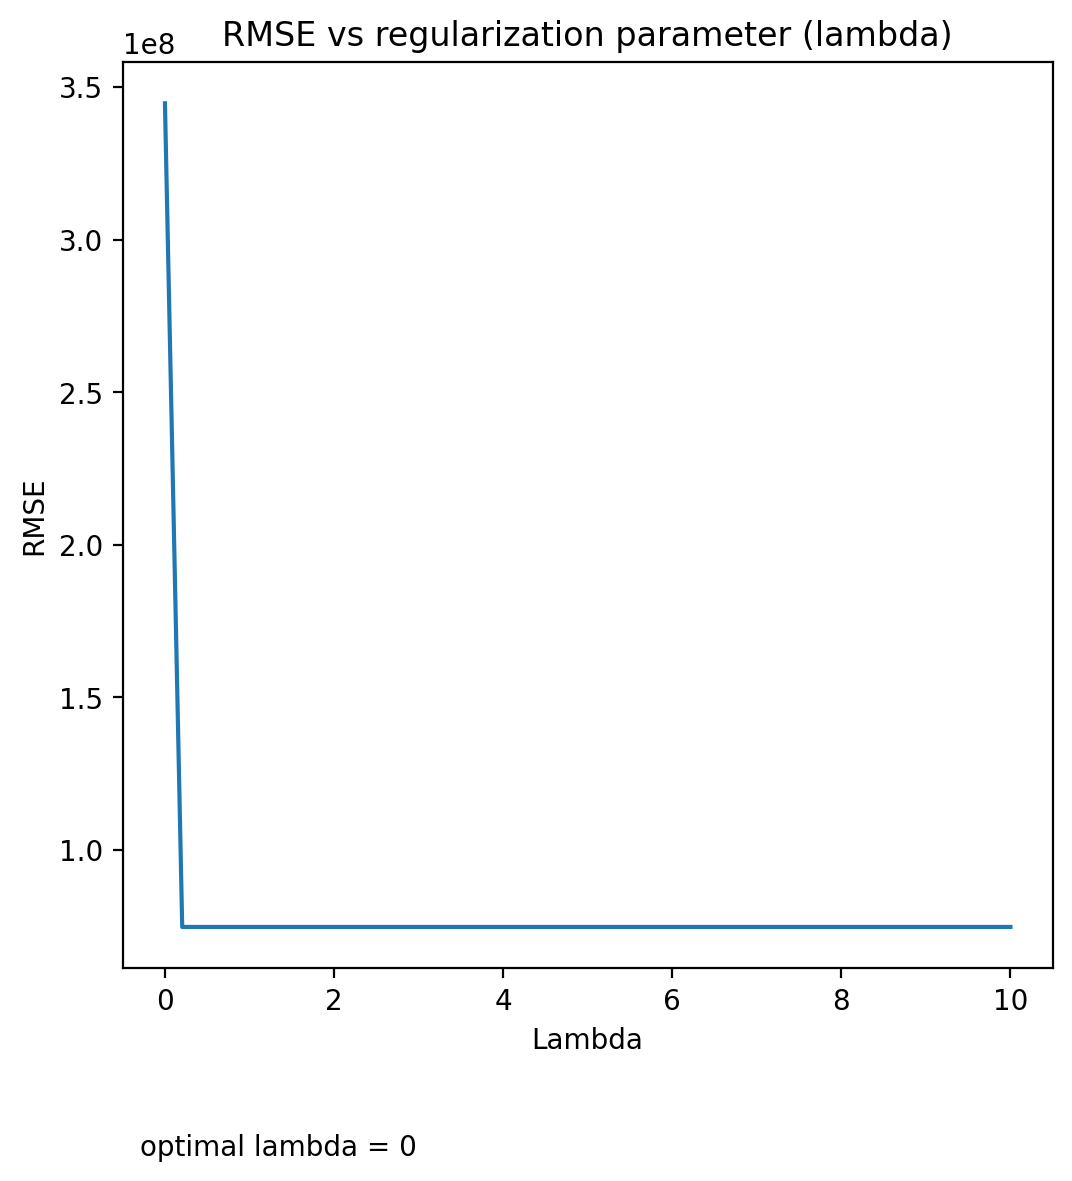

In [72]:
cwd = os.getcwd()
data_dir = '/Users/sps253/Documents/stroke-graph-matching/data'
fc_dir =data_dir + '/precision/'
output_prec = sio.loadmat(fc_dir + 'FCprec_concat_allsub.mat')
rmse = output_prec['rmse'] 
opt_gamma = output_prec['gamma'] 
gridsearch=np.linspace(0, 10,50)

figure(num=None, figsize=(6, 6), dpi=200, facecolor='w', edgecolor='k')

plt.plot(gridsearch,rmse.transpose())
plt.ylabel('RMSE')
plt.xlabel('Lambda')
plt.title('RMSE vs regularization parameter (lambda)')
plt.text(opt_gamma-0.3, 0.5, 'optimal lambda = ' + str(round(opt_gamma[0][0],3)))
results_dir = '/Users/sps253/Documents/stroke-graph-matching/'
plt.savefig(results_dir + 'optimal_gamma_ctrl.png')

In [32]:
np.linspace(200, 1000,50)

array([ 200.        ,  216.32653061,  232.65306122,  248.97959184,
        265.30612245,  281.63265306,  297.95918367,  314.28571429,
        330.6122449 ,  346.93877551,  363.26530612,  379.59183673,
        395.91836735,  412.24489796,  428.57142857,  444.89795918,
        461.2244898 ,  477.55102041,  493.87755102,  510.20408163,
        526.53061224,  542.85714286,  559.18367347,  575.51020408,
        591.83673469,  608.16326531,  624.48979592,  640.81632653,
        657.14285714,  673.46938776,  689.79591837,  706.12244898,
        722.44897959,  738.7755102 ,  755.10204082,  771.42857143,
        787.75510204,  804.08163265,  820.40816327,  836.73469388,
        853.06122449,  869.3877551 ,  885.71428571,  902.04081633,
        918.36734694,  934.69387755,  951.02040816,  967.34693878,
        983.67346939, 1000.        ])

In [5]:
opt_gamma

array([[0.71428571]])